# Decision Tree from scikit-learn

See full documentations at https://scikit-learn.org/stable/modules/tree.html

In [2]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn import metrics

plt.rcParams['figure.figsize'] = (15, 15)

In [3]:
X, y = load_iris(return_X_y=True)
clf = tree.DecisionTreeClassifier(criterion = "entropy", max_depth = 3)
clf = clf.fit(X, y)

[Text(313.875, 713.475, 'X[2] <= 2.45\nentropy = 1.585\nsamples = 150\nvalue = [50, 50, 50]'),
 Text(209.25, 509.625, 'entropy = 0.0\nsamples = 50\nvalue = [50, 0, 0]'),
 Text(418.5, 509.625, 'X[3] <= 1.75\nentropy = 1.0\nsamples = 100\nvalue = [0, 50, 50]'),
 Text(209.25, 305.775, 'X[2] <= 4.95\nentropy = 0.445\nsamples = 54\nvalue = [0, 49, 5]'),
 Text(104.625, 101.92499999999995, 'entropy = 0.146\nsamples = 48\nvalue = [0, 47, 1]'),
 Text(313.875, 101.92499999999995, 'entropy = 0.918\nsamples = 6\nvalue = [0, 2, 4]'),
 Text(627.75, 305.775, 'X[2] <= 4.85\nentropy = 0.151\nsamples = 46\nvalue = [0, 1, 45]'),
 Text(523.125, 101.92499999999995, 'entropy = 0.918\nsamples = 3\nvalue = [0, 1, 2]'),
 Text(732.375, 101.92499999999995, 'entropy = 0.0\nsamples = 43\nvalue = [0, 0, 43]')]

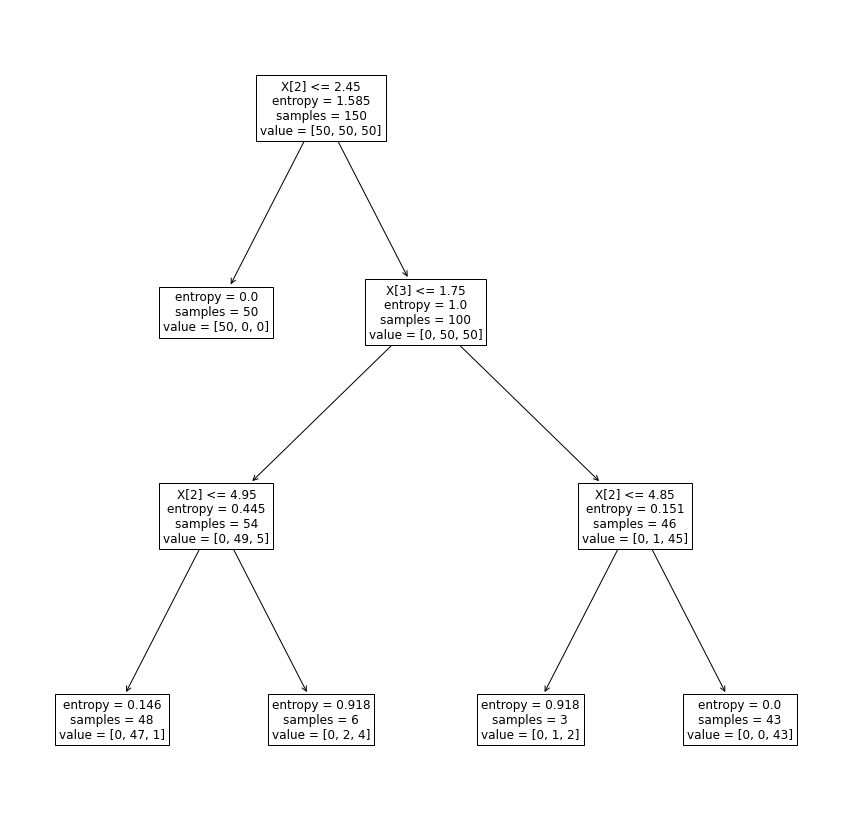

In [4]:
tree.plot_tree(clf, fontsize=12)

In [5]:
yp = clf.predict(X)

# summarize the fit of the model
print(metrics.classification_report(y, yp))
print(metrics.confusion_matrix(y, yp))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.98      0.94      0.96        50
           2       0.94      0.98      0.96        50

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150

[[50  0  0]
 [ 0 47  3]
 [ 0  1 49]]


# Clustering

Most of the algorithms that we have discussed so far are what’s known as *supervised learning* algorithms,
in that they start with a set of labeled data and use that as the basis for making
predictions about new, unlabeled data.

Clustering, however, is an example of *unsupervised
learning*, in which we work with completely unlabeled data (or in which our
data has labels but we ignore them).

## The Idea

Whenever you look at some source of data, it’s likely that the data will somehow form
clusters.
- A dataset showing where millionaires live probably has clusters in places like Beverly Hills and Manhattan.
- A dataset showing how many hours people work each week probably has a cluster around 40 (and if it’s taken from a state with laws mandating special benefits for people who work at least 20 hours a week, it probably has another cluster right around 19).
- A dataset of demographics of registered voters likely forms a variety of clusters (e.g., “soccer moms,” “bored retirees,” “unemployed millennials”) that pollsters and political consultants consider relevant.

Unlike some of the problems we’ve looked at, there is generally no “correct” clustering.
- An alternative clustering scheme might group some of the “unemployed millennials” with “grad students,” and others with “parents’ basement dwellers.”

Neither scheme is necessarily more correct—instead, each is likely more optimal with respect
to its own “how good are the clusters?” metric.

Furthermore, the clusters won’t label themselves. You’ll have to do that by looking at
the data underlying each one.

## The Model

For us, each `input` will be a vector in *d*-dimensional space, which, as usual, we will
represent as a list of numbers. Our goal will be to identify clusters of similar inputs
and (sometimes) to find a representative value for each cluster.

For example, imagine that we have a
picture containing thousands of `(red, green, blue)` (RGB) colors and that we need to
screen-print a 10-color version of it. Clustering can help us choose 10 colors that will
minimize the total “color error.”

One of the simplest clustering methods is *k*-means, in which the number of clusters *k*
is chosen in advance, after which the goal is to partition the inputs into sets $S_1, \dots, S_k$
in a way that minimizes the total sum of squared distances from each point to the
mean of its assigned cluster.

There are a lot of ways to assign *n* points to *k* clusters, which means that finding an
optimal clustering is a very hard problem. We’ll settle for an iterative algorithm that
usually finds a good clustering:
1. Start with a set of *k*-means, which are points in *d*-dimensional space.
2. Assign each point to the mean to which it is closest.
3. If no point’s assignment has changed, stop and keep the clusters.
4. If some point’s assignment has changed (moving from one cluster to another), recompute the means and return to step 2.

To start with, we’ll create a helper function that measures how many coordinates two
vectors differ in. We’ll use this to track our training progress:

In [6]:
from typing import List
Vector = List[float]

def num_differences(v1: Vector, v2: Vector) -> int:
    assert len(v1) == len(v2)
    return len([x1 for x1, x2 in zip(v1, v2) if x1 != x2])

In [7]:
print(num_differences([1, 2, 3], [2, 1, 3]))
print(num_differences([1, 2], [1, 2]))

2
0


We also need a function that, given some vectors and their assignments to clusters,
computes the means of the clusters.

It may be the case that some cluster has no points assigned to it. We can’t take the mean of an empty collection, so in that case we’ll just
randomly pick one of the points to serve as the “mean” of that cluster:

In [8]:
import numpy as np

def cluster_means(k: int,
                  inputs: List[Vector],
                  assignments: List[int]) -> List[Vector]:
    
    # clusters[i] contains the inputs whose assignment is i
    clusters = [[] for i in range(k)]
    
    for input, assignment in zip(inputs, assignments):
        clusters[assignment].append(input)

    # if a cluster is empty, just use a random point
    # np.mean (..., axis = 0) will compute mean of vectors across axis 0 (rows)
    return [np.mean(cluster, axis = 0) if cluster else random.choice(inputs)
            for cluster in clusters]

And now we’re ready to code up our clusterer. As usual, we’ll use `tqdm` to track our
progress, but here we don’t know how many iterations it will take, so we then use
`itertools.count`, which creates an infinite iterable, and we’ll `return` out of it when
we’re done:

In [9]:
import itertools
import random
import tqdm
from scipy.spatial import distance

class KMeans:
    def __init__(self, k: int) -> None:
        self.k = k                      # number of clusters
        self.means = None

    def classify(self, input: Vector) -> int:
        """return the index of the cluster closest to the input"""
        return min(range(self.k),
                   key=lambda i: distance.euclidean(input, self.means[i]))

    def train(self, inputs: List[Vector]) -> None:
        # Start with random assignments
        assignments = [random.randrange(self.k) for _ in inputs]

        with tqdm.tqdm(itertools.count()) as t:
            for _ in t:
                # Compute means and find new assignments
                self.means = cluster_means(self.k, inputs, assignments)
                new_assignments = [self.classify(input) for input in inputs]

                # Check how many assignments changed and if we're done
                num_changed = num_differences(assignments, new_assignments)
                if num_changed == 0:
                    return

                # Otherwise keep the new assignments, and compute new means
                assignments = new_assignments
                self.means = cluster_means(self.k, inputs, assignments)
                t.set_description(f"changed: {num_changed} / {len(inputs)}")

Now let’s take a look at how this works.

## Example: Meetups

To celebrate the grow of your social network start-up company, your VP of User Rewards wants to organize
several in-person meetups for your hometown users, complete with beer, pizza, and t-shirts. You know the locations of all your local users 
and she’d like you to choose meetup locations that make it convenient for everyone to
attend.

![The locations of your hometown users](location.jpg)

Depending on how you look at it, you probably see two or three clusters. (It’s easy to
do visually because the data is only two-dimensional. With more dimensions, it
would be a lot harder to eyeball.)

Imagine first that she has enough budget for three meetups. You go to your computer
and try this:

In [10]:
inputs: List[List[float]] = [[-14,-5],[13,13],[20,23],[-19,-11],[-9,-16],[21,27],[-49,15],[26,13],[-46,5],[-34,-1],[11,15],[-49,0],[-22,-16],[19,28],[-12,-8],[-13,-19],[-41,8],[-11,-6],[-25,-9],[-18,-3]]

random.seed(12)                   # so you get the same results as me
clusterer = KMeans(k=3)
clusterer.train(inputs)

changed: 5 / 20: : 1it [00:00, 331.04it/s]


In [11]:
print(clusterer.means)

[array([-43.8,   5.4]), array([18.33333333, 19.83333333]), array([-15.88888889, -10.33333333])]


You find three clusters centered at [–44, 5], [–16, –10], and [18, 20], and you look for
meetup venues near those locations

![User locations grouped into three clusters](3_clusters.jpg)

You show your results to the VP, who informs you that now she only has enough
budgeted for two meetups.

“No problem,” you say:

In [12]:
random.seed(0)
clusterer = KMeans(k=2)
clusterer.train(inputs)

changed: 4 / 20: : 2it [00:00, 401.08it/s]


In [13]:
print(clusterer.means)

[array([18.33333333, 19.83333333]), array([-25.85714286,  -4.71428571])]


So now one meetup should still be near [18, 20], but now the other
should be near [–26, –5].

![User locations grouped into two clusters](2_clusters.jpg)

## Choosing k

In the previous example, the choice of *k* was driven by factors outside of our control.
In general, this won’t be the case. 

There are various ways to choose a *k*. One that’s
reasonably easy to understand involves plotting the sum of distances/errors (between
each point and the mean of its cluster) as a function of *k* and looking at where the
graph “bends”:

In [14]:
def sum_clustering_errors(inputs: List[Vector], k: int) -> float:
    """finds the total error from k-means clustering the inputs"""
    clusterer = KMeans(k)
    clusterer.train(inputs)
    means = clusterer.means
    assignments = [clusterer.classify(input) for input in inputs]

    return sum(distance.euclidean(input, means[cluster])
               for input, cluster in zip(inputs, assignments))

which we can apply to our previous example:

0it [00:00, ?it/s]
changed: 8 / 20: : 1it [00:00, 331.72it/s]
changed: 2 / 20: : 2it [00:00, 504.24it/s]
changed: 2 / 20: : 2it [00:00, 401.18it/s]
changed: 2 / 20: : 4it [00:00, 363.81it/s]
changed: 1 / 20: : 3it [00:00, 300.83it/s]
changed: 1 / 20: : 5it [00:00, 334.74it/s]
changed: 4 / 20: : 2it [00:00, 251.39it/s]
changed: 2 / 20: : 3it [00:00, 231.39it/s]
changed: 4 / 20: : 3it [00:00, 231.85it/s]
changed: 1 / 20: : 3it [00:00, 214.88it/s]
changed: 1 / 20: : 3it [00:00, 200.59it/s]
changed: 1 / 20: : 3it [00:00, 167.29it/s]
changed: 1 / 20: : 3it [00:00, 187.88it/s]
changed: 1 / 20: : 4it [00:00, 182.15it/s]
changed: 3 / 20: : 3it [00:00, 166.90it/s]
changed: 1 / 20: : 4it [00:00, 160.43it/s]
changed: 3 / 20: : 3it [00:00, 136.77it/s]
changed: 3 / 20: : 3it [00:00, 130.67it/s]
changed: 1 / 20: : 5it [00:00, 139.24it/s]


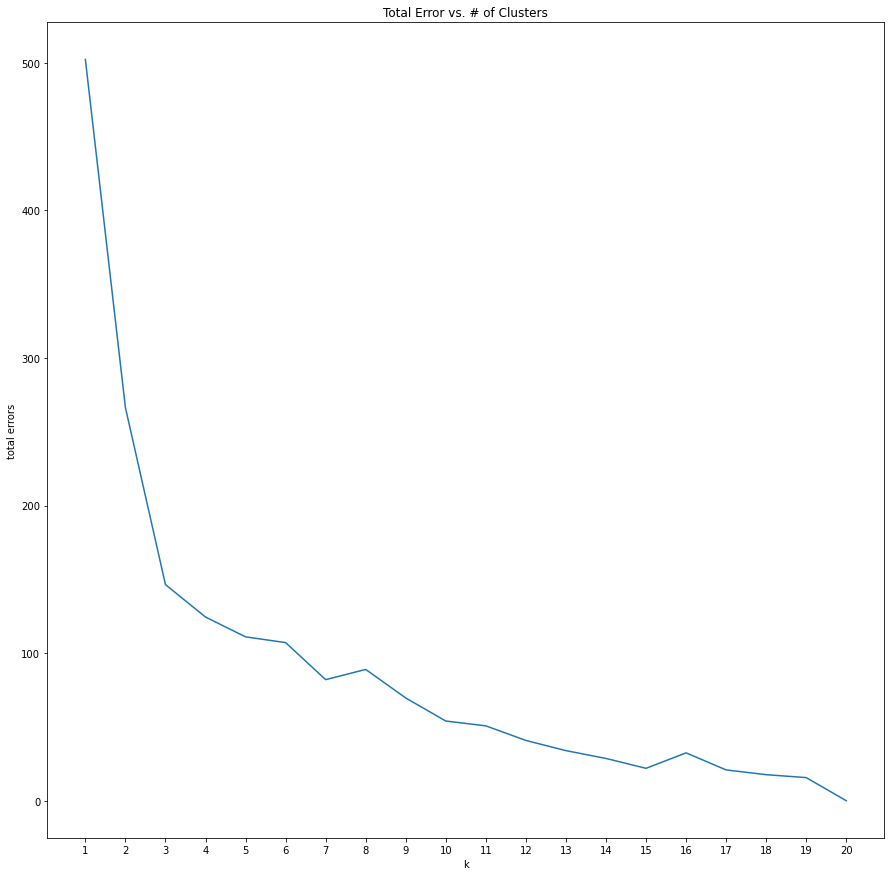

In [15]:
# now plot from 1 up to len(inputs) clusters

ks = range(1, len(inputs) + 1)
errors = [sum_clustering_errors(inputs, k) for k in ks]

plt.plot(ks, errors)
plt.xticks(ks)
plt.xlabel("k")
plt.ylabel("total errors")
plt.title("Total Error vs. # of Clusters")
plt.show()

Judging by the figure, this method agrees with our original eyeballing that three is
the “right” number of clusters.